<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

Text Classification using Gradient Boosting Classifier and TfidfVectorizer

This Code Template is for Text Classification using Gradient Boosting Classifier along with the Text Feature technique TfidfVectorizer from Scikit-learn in python. TF-IDF is used to reduce the weight of tokens that appear frequently compared to tokens that appear rarely. 

### Required Packages

In [ ]:
!pip install nltk
!pip install imblearn

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as se
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.ensemble import GradientBoostingClassifier

### Initialization

Filepath of CSV file

In [ ]:
#filepath
file_path= ""

**Target** variable for prediction.

In [ ]:
target=''

Text column containing all the text data


In [ ]:
text=""

## Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [ ]:
df=pd.read_csv(file_path)
df.head()

,Unnamed: 0,ItemID,Sentiment,SentimentSource,SentimentText
0,1,1,0,Sentiment140,is so sad for my APL friend.............
1,2,2,0,Sentiment140,I missed the New Moon trailer...
2,3,3,1,Sentiment140,omg its already 7:30 :O
3,4,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,5,5,0,Sentiment140,i think mi bf is cheating on me!!! T_T


### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# STEMMING
# Initialize the Stemmer
ps = PorterStemmer()

# Stem the sentence
def stemmer(string):
    return ps.stem(string)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Lemmatize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def textlemmapreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

def textstempreprocess(string):
    return stemmer(stopword(preprocess(string)))

def textfinalpreprocess(df, modifier = 'stemmer'):
    if modifier == 'lemmatization':
        return(df[text].apply(lambda x: textlemmapreprocess(x)))
    elif modifier == 'stemmer':
        return(df[text].apply(lambda x: textstempreprocess(x)))

def data_preprocess(df, target):
    df = df.dropna(axis=0, how = 'any')
    df[target] = LabelEncoder().fit_transform(df[target])    
    return df

In [ ]:
df = data_preprocess(df, target)
df[text] = textfinalpreprocess(df, modifier = 'stemmer') #modifier has two options: 'stemmer', 'lemmatization'
df.head()

,Unnamed: 0,ItemID,Sentiment,SentimentSource,SentimentText
0,1,1,0,Sentiment140,sad apl friend
1,2,2,0,Sentiment140,missed new moon trail
2,3,3,1,Sentiment140,omg alreadi
3,4,4,0,Sentiment140,omgaga im sooo im gunna cry dentist since supo...
4,5,5,0,Sentiment140,think mi bf ch


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [ ]:
X=df[text]
Y=df[target]

#### Distribution Of Target Variable

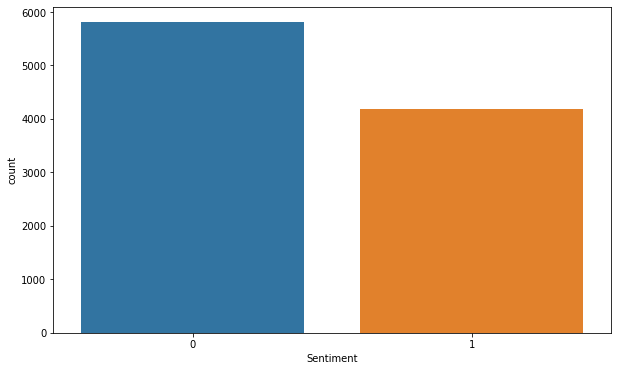

In [ ]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Data Splitting
Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### Feature Transformation

**TfidfVectorizer** converts a collection of raw documents to a matrix of TF-IDF features.

It's equivalent to CountVectorizer followed by TfidfTransformer.

For more information on TfidfVectorizer [click here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

## Model

Gradient Boosting for classification.

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.



#### Model Tuning Parameters
    1.loss{‘deviance’, ‘exponential’}, default=’deviance’
>The loss function to be optimized. ‘deviance’ refers to deviance (= logistic regression) for classification with probabilistic outputs. For loss ‘exponential’ gradient boosting recovers the AdaBoost algorithm.

    2.learning_ratefloat, default=0.1
>Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

    3.n_estimatorsint, default=100
>The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

    4.subsamplefloat, default=1.0
>The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

    5.criterion{‘friedman_mse’, ‘mse’, ‘mae’}, default=’friedman_mse’
>The function to measure the quality of a split. Supported criteria are ‘friedman_mse’ for the mean squared error with improvement score by Friedman, ‘mse’ for mean squared error, and ‘mae’ for the mean absolute error. The default value of ‘friedman_mse’ is generally the best as it can provide a better approximation in some cases.

    6.min_samples_splitint or float, default=2
>The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.


    7.min_samples_leafint or float, default=1
>The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.


    8.min_weight_fraction_leaffloat, default=0.0
>The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

    9.max_depthint, default=3
>The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

For more information on GBClassifier and it's parameters [click here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [ ]:
model=GradientBoostingClassifier(n_estimators=500, random_state=123)
model.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Model Accuracy
score() method return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(x_test,y_test)*100))

Accuracy score 74.05 %



#### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

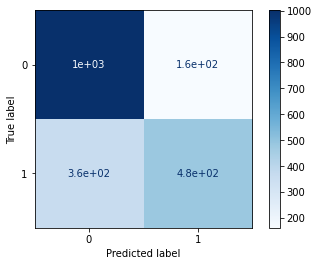

In [ ]:
plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.
* where:
  - Precision:- Accuracy of positive predictions.
  -  Recall:- Fraction of positives that were correctly identified.
  -  f1-score:- percent of positive predictions were correct
  -  support:- Support is the number of actual occurrences of the class in the specified dataset.

In [ ]:
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      1162
           1       0.75      0.57      0.65       838

    accuracy                           0.74      2000
   macro avg       0.74      0.72      0.72      2000
weighted avg       0.74      0.74      0.73      2000



#### Creator: Anu Rithiga B , Github: [Profile - Iamgrootsh7](https://github.com/iamgrootsh7)